# 機械学習
一部抜粋しながら機械学習の概要をまとめる。

『機械学習とは、データから「学習」する方法やアルゴリズムを開発することを目的とした科学分野である。』

本稿では機械学習における２つの分野について理論をまとめ、Julia言語によって実装していく。
* 教師あり学習
    * 『教師あり学習とは、全てのデータがラベル付けされている機械学習のことである。』
    * 分類問題や回帰問題が解ける。
* 教師無し学習
    * 『教師無し学習の目的は、与えられたデータ集合の基礎となる構造を解明することである。』
    * クラスタリングや次元削減，確率分布推定ができる。

これらの他にも、機械学習には以下のような手法もある。
* 強化学習
    * 『エージェントが目的を達成したり、目的関数を最大したりするような行動の系列を学習すること。』
    * 環境とエージェントを用意し、試行錯誤をしながら報酬によって行動を学習する。
    * 自動制御に起源を持つ。
    
【参考文献】
* 田中, 富谷, 橋本. [ディープラーニングと物理学](https://bookclub.kodansha.co.jp/product?item=0000318303). 講談社. 2019.


### パッケージの読み込み
以下のパッケージを用いる。
特に`Distributions`を多用する。


In [1]:
### packages
# IJulia
using Interact#, WebIO
#WebIO.install_jupyter_labextension(condajl=true)

# develop
using ArgCheck, BenchmarkTools
using Plots # プロット

# text
using LaTeXStrings, Latexify # LaTeXの利用


# calculate
using Base: oneto, promote_type, promote_eltype, count_ones
using LinearAlgebra, StaticArrays, AffineMaps # 配列
using Optim # 最小値問題を解く
using Distributions # 確率分布
using Distributions: @check_args
using Statistics, StatsBase # 統計寮の計算
using StatsPlots # 分布やデータのプロット

# data 
using MLDatasets, DataFrames, MLUtils # データセット
using MLJBase: matrix

#=
### julia packages
# statics
using StatsModels, GLM
using Turing
# ML
using Flux
=#


WebIO._IJuliaInit()

# 理論の基礎

## 情報理論の基礎のキソ

参考文献
* 黒木玄. [Kullback-Leibler情報量とSanovの定理](https://genkuroki.github.io/documents/20160616KullbackLeibler/20160616KullbackLeibler-0.6.pdf). 


### Sanovの定理とエントロピー
関数 $p, q$ をそれぞれ確率とする。
「$m$ 個の事象 $(A_i)_{i=1,\cdots,m}$ が発生する確率がそれぞれ $q_i$ である。」
と仮定すれば、
\begin{equation}
\left( \,
	n \mathrm{回の独立試行で経験分布がほぼ}p_i \mathrm{になる確率}
\, \right)
	= \exp [n S(p,q)] \quad (n \to \infty)
\end{equation}
が成立する。ここで $S(p,q)$ は**相対エントロピー**と呼ばれる以下で定義される関数である：[^1]
\begin{equation}
S(p\|q) := - \mathbb{E}_p \left[ \log \frac{p}{q} \right] \quad (\leq 0) .
\end{equation}
つまり $p$ を経験分布に近付けることは、相対エントロピーを大きくする事によって実現できる。
これを**最大相対エントロピー原理**と呼ぶ。

また２つの関数を定義する。
* **情報エントロピー** $S(q) := - \mathbb{E}_q[\log q]$
* **交差エントロピー** $S(p,q) := - \mathbb{E}_p[\log q]$

各エントロピーの定義より、
\begin{equation}
S(q\|p) = S(q) - S(q,p)
\end{equation}
が成立する。本稿ではエントロピーの関係式と呼ぶ。
$q$ を真の分布，あるいは母集団分布とすれば情報エントロピー $S(q)$ は一定であるため、相対エントロピー $S(p\|q)$ の最大化は交差エントロピー $S(p,q)$ の最小化によって実現できる。

[^1]: 相対エントロピーの符合を反転した関数、$D(p\|q) := - S(p\|q)$をKullback-Leibler情報量（KLダイバージェンス）と呼ぶ。


### 統計学におけるカノニカル分布

#### カノニカル分布の導出
次のような、拘束条件のある相対エントロピー $S(q(x)\|p(x))$ の最大値問題を考える。
\begin{equation}
\max_{p(x)} S(p(x)\|q(x)) \quad \mathrm{s.\!t.} \:\: E_{p(x)}[1] = 1 \, , \:\: \mathbb{E}_{p(x)}[H_\omega(x)] = U
\end{equation}
ここで関数 $H_\omega$ をハミルトニアン，（確率）変数 $x$ が与えられたときの関数の値 $H_\omega(x)$ をエネルギーと呼ぶ。
この条件を満足する解は、逆温度と呼ばれる実変数 $\beta$ を用いて
\begin{equation}
p_\omega(x) = \frac{1}{Z} q(x) \exp [-\beta H_\omega(x)]
, \quad
Z(\beta) = \mathbb{E}_{q(x)} \left[ \exp [-\beta H_\omega(x)] \right]
\end{equation}
と記述でき、統計学におけるカノニカル分布が自然に導かれる。

エネルギーの期待値について、拘束条件を
\begin{equation}
\mathbb{E}_{p(x)}[H_\omega(x)] = U
\quad \longrightarrow \quad
\beta \: \mathbb{E}_{p(x)}[H_\omega(x)] \leq \beta \: U
\end{equation}
と緩めてもカノニカル分布は相対エントロピーを最大化する分布である。
これは逆温度 $\beta$ のカノニカル分布を $p_\beta(x)$ とするとき、Sanovの定理を用いて
\begin{equation}
S(p(x)\|q(x)) \leq S(p(x)\|p_\beta(x)) + S(p_\beta(x)\|q(x))) \leq S(p_\beta(x)\|q(x))
\end{equation}
が得られることから示せる。


#### カノニカル分布とエントロピー
エネルギーの平均について
\begin{equation}
U = - \frac{\partial \log Z}{\partial \beta}
\end{equation}
が成立する。
また自由エネルギーを $F(\beta) := - \frac{1}{\beta} \, \log Z(\beta)$ と
すれば、
\begin{equation}
S(p\|q) = \beta \, (U - F)
\end{equation}
が成立する。


#### 統計力学におけるカノニカル分布
統計力学では等重率の原理によって $q$ が一様分布であることを仮定している。
この仮定により、統計力学におけるカノニカル分布
\begin{equation}
p(x) = \frac{1}{Z} \exp [-\beta H(x)]
, \quad
Z(\beta) = \int \exp [-\beta H(x)] \, dx
\end{equation}
が得られる。


## ベイズ統計の基礎のキソ

【参考文献】
* 渡辺澄夫. [ベイズ統計の理論と方法](https://www.coronasha.co.jp/np/isbn/9784339024623/). コロナ社. 2012.


### ベイズ統計における主要な概念
互いに独立な $n$ 個のサンプルを $x^n = (x_i)_{i=1,\cdots, n}$とする。
サンプルを表す確率変数を$X^n$ とし、
\begin{equation}
X^n \sim q(x^n) = \prod_{n=1}^n q(x_i)
\end{equation}
となる分布 $q(x)$ を**真の分布**と呼ぶ。

観測可能であるサンプル $x^n$ を用いて、（予測）分布 $p(x|x^n)$ を 真の分布 $q(x)$ に近付ける方法を考察する。
* **事前分布**：確率モデルのパラメータが従う分布 $\varphi(\omega)$ 
* **確率モデル**：パラメータ $\omega$ が与えられたときの条件付確率 $p(x|\omega)$

これらを用いて、**逆温度** $\beta \in \mathbb{R}$ の**事後分布** $p(\omega|X^n)$ と**分配関数** $Z_n(\beta)$ をそれぞれ次で定める。
\begin{equation}
p(\omega|X^n) = \frac{1}{Z_n(\beta)} \varphi(\omega) \prod_{i=1}^n p(X_i|\omega)^\beta
, \quad
Z_n(\beta) = \int \prod_{i=1}^n p(X_i|\omega)^\beta * \varphi(\omega) \, d\omega
\end{equation}
事後分布は、サンプルから推測されるパラメータの分布である。

確率モデル $p(x|\omega)$ と事後分布 $p(\omega|X^n)$ を用いて、**予測分布**を次で定める：
\begin{equation}
p(x|X^n) = \mathbb{E_{p(\omega|X^n)}}[p(x|\omega)]
	= \int p(x|\omega) * p(\omega|X^n) \, d\omega .
\end{equation}
この予測分布 $p(x|X^n)$ を真の分布 $q(x)$ に近付けることがベイズ推定の目標である。

事前分布 $\varphi(\omega)$ が「パラメータの本当の事前分布」であり、
なおかつ確率モデル $p(x|\omega)$ が「パラメータが絶えられたときの、本当の条件付き確率」であれば、
加法定理より、$\beta=1$ での事後分布 $p(\omega|X^n)$ は「サンプル $X^n$ が観測されたという条件下での、パラメータの本当の条件付き確率」になっている。


逆温度$\beta=1$における分配関数 $Z_n(1)$ は、確率モデルと事前分布から予測されたサンプルの確率変数 $X^n$ の確率分布である。
そのことを強調する際には $p(X^n)$ と書き、**周辺尤度**と呼ぶ。つまり、
\begin{equation}
p(X^n) = Z_n(1) = \int \prod_{i=1}^n p(X_i|\omega) * \varphi(\omega) \, d\omega.
\end{equation}

サンプル $X^n$ から推定される予測分布を $p(X_{n+1}|X^n)$ とすると、
\begin{equation}
p(X_{n+1}|X^n)
= \frac{1}{Z_n(\beta)} \int p(X_{n+1}|\omega) \prod_{i=1}^n p(X_i|\omega) * \varphi(\omega) \, d\omega
= \frac{Z_{n+1}}{Z_n}
\end{equation}
が成立する。


#### カノニカル分布との関係
事後分布 $p(\omega|X^n)$ の定義は
\begin{equation}
p(\omega|X^n) = \frac{1}{Z_n(\beta)} \varphi(\omega) \prod_{i=1}^n p(X_i|\omega)^\beta
, \quad
Z_n(\beta) = \int \varphi(\omega) \prod_{i=1}^n p(X_i|\omega)^\beta \, d\omega .
\end{equation}
であった。
ここで事後分布を逆温度$\beta$のカノニカル分布と見なすと、対応するハミルトニアンは
\begin{equation}
H_\omega(X^n) = - \frac{1}{\beta} \log \varphi(\omega) - \sum_{i=1}^n \log p(X_i|\omega)
\end{equation}
となる。
このハミルトニアンは確率変数によって値が決まるため、**ランダムハミルトニアン**とも呼ばれる。

ここで、事前分布の対数尤度関数 $L(\varphi)$ と 確率モデルの対数尤度関数 $L_n(\omega)$ をそれぞれ
\begin{align}
L(\varphi)  &:= \log \varphi(\omega) \\
L_n(\omega) &:= \frac{1}{n} \sum_{i=1}^n \log p(X_i|\omega)
\end{align}
と定義すれば、ハミルトニアンは
\begin{equation}
H_\omega(X^n) = - \frac{1}{\beta} L(\varphi(\omega)) - n L_n(\omega)
\end{equation}
と記述できる。
これより、ベイズ統計はハミルトニアンとするカノニカル分布の統計力学と本質的に同じとみなせる。
また、
\begin{equation}
H_\omega(x) = - n L_n(\omega), \quad p(X^n|\omega) = \prod_{i=1}^n p(X_i|\omega) = \exp (- n L_n(\omega))
\end{equation}
であるから、統計学における対数尤度関数の$-1$倍はハミルトニアンと見なせる。


#### 自由エネルギーを用いた推定
自由エネルギーを次のように定義する：
\begin{equation}
F_n(\beta) = - \frac{1}{\beta} \, \log Z_n(\beta).
\end{equation}
逆温度 $\beta=1$ における自由エネルギー $F_n(1)$ のサンプルについて期待値をとると、
\begin{equation}
\mathbb{E}_{q(X^n)}[F_n(1)] = S(q(X^n),p(X^n)) = nS(q(x)) - S(q(X^n)\|p(X^n))
\end{equation}
が得られる。
自由エネルギー $F_n(1)$ の最小化によって確率 $p(x|X^n)$ を真の確率 $q(x)$ に一定の精度で近付けることが読み取れる。


#### 汎化損失を用いた推定
汎化損失を次式で定義する：
\begin{equation}
G_n = S(q(x),p(x|X^n)).
\end{equation}
汎化損失 $G_n$ を最小化することで 確率 $p(x|X^n)$ を真の確率 $q(x)$ に近付けたい。
しかし汎化損失 $G_n$ は観測できないので、観測可能な量である経験誤差
\begin{equation}
T_n = - \frac{1}{n} \sum_{i=1}^n \log p(x_i|X^n)
\end{equation}
を用いて $G_n$ を推測し、最小化を考える。

汎化損失 $G_n$ と自由エネルギー $F_n(1)$ の間には、
\begin{equation}
\mathbb{E}[G_n] = \mathbb{E}[F_{n+1}(1)] - \mathbb{E}[F_n(1)]
\end{equation}
という関係が成り立つ。
これは汎化損失 $G_n$ が小さいことと自由エネルギー $F_n(1)$ が小さいことは関係はあるが、等価ではないことを意味する。


### 逆温度について
直感的には、逆温度は事前分布 $\varphi(\omega)$ をどの程度信頼するかという目安になる。

例えば逆温度を $\beta=0$ とすると、事後分布は事前分布と等しくなる：
\begin{equation}
p(\omega|X^n) = \varphi(\omega) .
\end{equation}
言い換えれば、事後分布がサンプル $x^n$ を考慮せずに事前分布のみを採用した分布になっている。

また既に述べたように逆温度が $\beta=1$ の場合、
事前分布 $\varphi(\omega)$ が「パラメータの本当の事前分布」であり、
かつ確率モデル $p(x|\omega)$ が「パラメータが与えられたときの、本当の条件付き確率」であれば、
事後分布 $p(\omega|X^n)$ は「サンプル $X^n$ が観測されたという条件下でのパラメータの本当の条件付き確率」になっている。

最後に、最尤推定で得られるパラメータを $\omega_\mathrm{ML}$ とする。つまり、
\begin{equation}
p(x|\omega) \leq p(x|\omega_\mathrm{ML})
\end{equation}
となる $\omega_\mathrm{ML}$ を用いる。
逆温度 $\beta \to \infty$ の極限における事後分布 $p(\omega|X^n)$ は次のように変形できる。
\begin{gather}
p(\omega|X^n)  = \varphi(\omega) \exp \left[
	- \beta \, \left( - \sum_{i=1}^n \log p(X_i|\omega) - F_n(\beta) \right)
\right] \\
\inf_\beta F_n(\beta) = \inf_{\beta} \left\{
	-\sum_{i=1}^n \log p(X_i|\omega_\mathrm{ML})
\right\}
\end{gather}
これは $\log \frac{p(X_i|\omega_\mathrm{ML})}{p_i(X_i|\omega)} \! > 1$ の場合、
\begin{equation}
p(\omega|X^n) \xrightarrow{\beta\to\infty} \varphi(\omega) \, \exp \! \left[
	\prod_{i=1}^n \log \frac{p(X_i|\omega_\mathrm{ML})}{p(X_i|\omega)}
\right] \, e^{-\infty} = 0
\end{equation}
となる。まとめると、
\begin{gather}
\int p(\omega|X^n) \, d\omega = 1 \\
p(x|\omega) < p(x|\omega_\mathrm{ML}) \Rightarrow \lim_{\beta\to\infty} p(\omega|X^n) = 0
\end{gather}
が成立する。
$\beta \to \infty$ の極限において、事後分布はデルタ関数（あるいはDirac測度）を用いて記述できると解釈できる。
例えば最尤推定量が唯一であれば、 $\delta(\omega-\omega_\mathrm{ML})$ である。
この場合 $\beta \to \infty$ でのベイズ推定は最尤推定と等価であり、言い換えると事前分布 $\varphi(\omega)$ を用いずデータの値のみを採用した分布になっている。


# Juliaによる実装

## 実装の準備

### ブラケット表記の設定
本稿ではベクトルはDiracの記法を用いる。
誤差逆伝播法の導出し易く、また誤差の伝播の方向が明確になる。


In [2]:
### bra-ket
# bra, ket
bra_str, ket_str = raw"<\!\!", raw"\!\!>"
bra(x) = string(bra_str, x, '|')
ket(x) = string('|', x, ket_str)

# scalar product
braket(x, y) = string(bra_str, x, '|', y, ket_str)
braket(x, m, y) = string(bra_str, x, '|', m, '|', y, ket_str)

# convert : bra-ket
bra_rep, ket_rep = raw"\<"=>bra_str, raw"\>"=>ket_str
braket(x) = replace(x, bra_rep, ket_rep)
braket!(x) = replace!(x, bra_rep, ket_rep)
#=
braketstring = latexstring ∘ braket
braketmarkdown = Markdown.parse ∘ braket
=#
                                                                                          
# macro
macro BKmath_str(s::String) Expr(:call, :braket, s) end
macro BK_str(s::String) Expr(:call, GlobalRef(LaTeXStrings, :latexstring), braket(s)) end


@BK_str (macro with 1 method)

## カノニカル分布を用いたニューラルネットワーク
以下では逆温度を $\beta = 1$ とした統計力学におけるカノニカル分布を用いる。
このハミルトニアン（とカノニカル分布）のパラメータを $J$ で表記する。
つまり、ハミルトニアン $H_{J}$ に対するカノニカル分布を
\begin{equation}
p_{J}(x) = \frac{1}{Z} \exp[-H_{J}(x)], \quad Z = \mathbb{E}_d[ \exp[-H_{J}(x)] ]
\end{equation}
とする。
これによりカノニカル分布はベイジアンネットワークと対応する。

また汎化損失と経験損失を区別しない場合は単に損失と呼ぶ。
その場合はサンプルから得られる真の分布と経験分布とが等しいと仮定している。
現実には真の分布と経験分布は異なるため、経験損失の最小化によって必ず汎化損失が最小化されるわけではない。
ベイズ推定の場合は、WAICを用いれば経験損失から汎化損失を近似的に得られる（事後分布が正規分布に近似できる場合、自由エネルギーはBIC,汎化損失はAICで近似できる）ため、これを最小化する。

サンプル $x^n$ が与えられてている場合、ハミルトニアンを定めればパラメータ $J$ から損失が定まる。
パラメータから損失を得る関数を損失関数と呼び、 $L(J)$ と書く。
適切なパラメータを推定するには、サンプル $x^n$ を用いて損失関数
\begin{equation}
L(J) = - \mathbb{E}_q [\log p_J(x)] = - \frac{1}{n} \sum_{i=1}^n \log p_J(x_i)
\end{equation}
を最小化するパラメータ $J$ を求める。


In [3]:
"""
	Hamiltonian{<:AbstractFloat}

カノニカル分布におけるハミルトニアンを決定するデータ型。
`Canonical`に渡すことによってカノニカル分布が得られる。

See also: [`Canonical`](@ref)
"""
abstract type Hamiltonian{T<:AbstractFloat} end

"""
	hamilonian_expr(::H) where H<:Hamiltonian

`Hamiltonian`の数式を返す。
"""
hamiltonian_expr(::H) where H<:Hamiltonian = hamiltonian_expr(H)


### utils
"""
	Base.eltype(::Type{<:Hamiltonian{T}}) where T<:AbstractFloat

配列の要素の型を返す。
"""
Base.eltype(::Type{<:Hamiltonian{T}}) where T<:AbstractFloat = T

"""
	ndims_features

特徴量空間の次元（特徴量の数）を返す。
"""
ndims_features

ndims_features(::H) where H<:Hamiltonian = ndims_features(H)


"""
    affine


See also: [`energy`](@ref)
"""
function affine end

affine(h::Hamiltonian) = MulAdd(getfield(h,1), getfield(h,2))

affine(h::Hamiltonian, x) = affine(h)(x)


### statistics physics
"""
    energy(h::Hamiltonian, x::Real)
    energy(d::Canonical)


See also: [`affine`](@ref), [`StatsBase.mean`](@ref)
"""
function energy end


energy

In [4]:
"""
	Canonical{S<:ValueSupport} <: UnivariateDistribution{S}

カノニカル分布の抽象型。
パラメータを与えれば、`Hamiltonian`から得られるカノニカル分布を返す。

See also: [`Hamiltonian`](@ref)
"""
abstract type Canonical{S<:ValueSupport} <: UnivariateDistribution{S} end

canonical(h::H, x) where H<:Hamiltonian = Canonical(H)(h, x)


### utils
Base.eltype(::Type{T}) where T<:Canonical = eltype(fieldtype(T, 1))

affine(d::Canonical) = affine(getfield.(d, oneto(2))...)


### static physics
# mean of enegy
energy(d::Canonical) = energy(getfield.(d, oneto(2))...)


### statistics
Distributions.logpdf(d::Canonical, args...) = (log∘pdf)(d, args...)

"""
	loss

経験対数損失関数（カノニカル分布と経験分布との交差エントロピー）を返す。

See also: [`Distributions.fit`](@ref)
"""
function loss end

loss(d::Canonical, args...) = - logpdf(d, args...)

loss(h::Hamiltonian, features, target::Real, args...) = loss(canonical(h, features), target, args...)
loss(h::Hamiltonian, features, targets::AbstractVector, args...) = sum(loss(h, feature, target, args...) for (feature,target) in zip(eachrow(features),targets))


loss (generic function with 3 methods)

In [5]:
### statistics
"""
	Distributions.fit(h::Hamiltonian, features, taergets)

カノニカル分布と経験分布との交差エントロピーを最小化するパラメータを返す。

See also: [`loss`](@ref), [`vcat_params`](@ref), [`params`](@ref)
"""
Distributions.fit

function Distributions.fit(h::Hamiltonian, features, targets::AbstractVector, args...; result::Bool=false)
	H, prms = typeof(h), vcat_params(h)
    Hamil = getproperty(Main, nameof(H))
	
	res = Optim.optimize(x -> loss(Hamil(params(H, x)...), features, targets, args...), prms)
	result && println(res)
    
	prms .= Optim.minimizer(res)
	Hamil(params(H, prms)...)
end

Distributions.fit(H::Type{<:Hamiltonian}, features, targets::AbstractVector, args...; keys...) = fit(H(features), features, targets, args...; keys...)

Distributions.fit(H::Type{<:Hamiltonian}, features::AbstractVector, targets::AbstractVector, args...; keys...) = fit(H(0), features, targets, args...; keys...)

"""
    vcat_params(h::Hamiltonian)

パラメータを`AbstractVector`に格納する関数。

See also: [`params`](@ref), [`Distributions.fit`](@ref)
"""
function vcat_params(h::Hamiltonian)
	a, b = (getfield(h, i) for i in oneto(2))
	vcat(vec(a), b) |> MVector{sum(length, (a,b))}
end

"""
     params(h::Hamiltonian, prms::AbstractVector{<:AbstractFloat})

`AbstractVector`に格納されたパラメータを元の形状に戻す関数。

See also:  [`params`](@ref), [`Distributions.fit`](@ref)
"""
function params(::Type{H}, prms::AbstractVector{<:AbstractFloat}) where H<:Hamiltonian
    T = fieldtype(H, 1)
	n, size_J = length(T), size(T)
    T(reshape(prms[begin:n], size_J)), prms[n+one(n):end]
end


params

## 教師あり学習
教師あり学習のデータは、特徴変数（独立変数） $x$ とラベル変数（ターゲット変数，従属変数） $d$ からなる観測値の対 $(x,d)$ で表現される。

ハミルトニアン $H_J(d,x)$ を定めれば、カノニカル分布
\begin{equation}
p_J(d|x) = \frac{1}{Z} \exp[-H_J(d,x)], \quad Z = \mathbb{E}_d \left[ \exp[-H_J(d,x)] \right] .
\end{equation}
が得られる。
特徴変数によってラベル変数を決定しているため、条件付確率になっている。

教師あり学習によって、以下の分析が行える。
*  分類　　　：　ラベル変数の値域が離散的
*  回帰分析　：　ラベル変数の値域が連続的

機械学習タスクの設計：
1. 特徴生成（特徴抽出）：生データを $l$ 個の特徴量に符号化し、特徴空間（入力空間）とよばれる $l$ 次元の空間に変換する。
1. 分類器を訓練する： $N$個のサンプルを選択し、訓練集合 $\{(d_i,x_i)\}_{i=1,\cdots,N}$ を用意し、特徴ベクトル $x$ が与えられたときに出力ラベルを予測する関数 $f$ の集合を設計する。


In [6]:
"""
     TData{Tf,Tt<:AbstractVector}

教師あり学習の特徴変数とラベル変数を格納する。

See also:  [`ClassifiData`](@ref)
"""
struct TData{Tf,Tt<:AbstractVector}
    """
        TData.features::Any
    
    特徴量のデータ。
    """
	features::Tf
    
    """
        TData.targets::AbstractVector
    
    ラベルのデータ。
    """
	targets::Tt
    
	function TData(features::Tf, targets::Tt) where {Tf,Tt<:AbstractVector}
		@argcheck size(features, 1) == length(targets)
		new{Tf,Tt}(features, targets)
	end
end
TData(features::AbstractDataFrame, targets::AbstractDataFrame) = TData(matrix(features), targets[!,1])

TData(data::NamedTuple{(:features,:targets)}) = TData(values(data)...)
TData(data::NTuple{2,ObsView}) = TData(getobs(data)...)


### interfaces
# length
Base.length(t::TData) = length(t.targets)
MLDatasets.numobs(t::TData) = length(t)
                                                                                                                                  
# index
Base.firstindex(::TData) = 1
Base.lastindex(t::TData) = length(t)
Base.getindex(t::TData, i::Integer) = firstindex(t)<=i<=lastindex(t) ? (t.features[i,:], t.targets[i]) : throw(BoundsError(t, i))

# iteration
Base.iterate(t::TData, i::Integer=1) = firstindex(t)<=i<=lastindex(t) ? (t[i], i+1) : nothing


### 分類問題
確率変数 $d$ が離散的な変数の教師あり学習は、分類問題を解くアルゴリズムである。
1. ２値分類：ラベル変数の値域は $\{0,1\}$
1. 多値分類： $n$ 値分類の場合、ラベル変数の値域は  $\{1,\cdots,n\}$

In [7]:
"""
	ClassifiParams{T} <: Hamiltonian{T}

分類器のハミルトニアン。

See also: [`ClassifiParams`](@ref)
"""
abstract type ClassifiParams{T<:AbstractFloat} <: Hamiltonian{T} end

"""
	Classification <: Canonical{Discrete}

分類器のカノニカル分布。

See also: [`Classification`](@ref)
"""
abstract type Classification <: Canonical{Discrete} end


Classification

#### ２値分類
ラベル変数 $d$ を集合 $\{0,1\}$ 上の確率変数とする。

ハミルトニアンを
\begin{equation}
H(d,x) = - d (<\!J|x_0\!> + J_0)
\end{equation}
とする。
このとき、カノニカル分布
\begin{equation}
p_J(d|x) = \frac{\exp(d(<\!J|x_0\!>+J_0))}{1+\exp(<\!J|x_0\!>+J_0)}.
\end{equation}
が得られる。

この分布は、
カノニカル分布の期待値を $\hat{d} = -(<\!J|x_0\!> + J_0)$ とすると、
sigmoid関数（logistic関数）
\begin{equation}
\sigma(x) = \frac{1}{1+\exp(-x)}
\end{equation}
を用いて次のように記述できる：
\begin{equation}
p_J(d=1|x) = 1-p_J(d=0|x) = \sigma(\hat{d}) = \sigma(<\!J|x_0\!>+J_0)
\end{equation}

In [8]:
"""
	BinaryParams{nf,T<:AbstractFloat} <: ClassifiParams{T}

２値分類のカノニカル分布。

!!! note
    `nc::Integer`は分類するクラスの数
    `nf::Integer`は特徴量空間の次元。

See also: [`BinaryClassifi`](@ref), [`ClassifiParams`](@ref), [`hamiltonian_expr`](@ref)
"""
struct BinaryParams{nf,T<:AbstractFloat} <: ClassifiParams{T}
    """
        v::Adjoint{T, MVector{nf,T}}
    """
	v::Adjoint{T, MVector{nf,T}}

    """
        v0::T
    """
	v0::T
    
	BinaryParams(v::Adjoint{<:Real}, v0::Real) = new{length(v),float(promote_eltype(v, v0))}(v, v0)
end
BinaryParams(v::AbstractVector, args...) = BinaryParams(adjoint(v), args...)
function BinaryParams(v, v0::AbstractVector)
	@argcheck length(v0) == 1 DomainError
	BinaryParams(v, only(v0))
end
BinaryParams(features) = BinaryParams(@MVector(ones(size(features, 2)))', 0)


### utils
hamiltonian_expr(::Type{<:BinaryParams}) = BK"H(d,x) = - d ( \<J|x_0\> + J_0) \quad (d \in \{0,1\})"

ndims_features(::Type{<:BinaryParams{nf,<:AbstractFloat}}) where nf = nf


ndims_features (generic function with 2 methods)

In [9]:
"""
	BinaryClassifi{nf,T<:AbstractFloat} <: Classification

２値分類のカノニカル分布。

See also: [`BinaryParams`](@ref), [`ClassifiParams`](@ref)
"""
struct BinaryClassifi{nf,T<:AbstractFloat} <: Classification
    """
        h::BinaryParams{nf,T}
    
    ２値分類のハミルトニアン。
    """
	h::BinaryParams{nf,T}
    
	"""
        features::SVector{nf,T}
    
    データ。
    """
	features::SVector{nf,T}
    
	function BinaryClassifi(h::BinaryParams, features; check_args=true)
		check_args && @check_args(BinaryClassifi, ndims_features(h)==length(features))
        nf = ndims_features(h)
		features_new = SVector{nf}(features...)
		new{nf,float(promote_eltype(h, features_new))}(h, features_new)
	end
end
BinaryClassifi(features) = BinaryClassifi(BinaryParams(features), features)

Canonical(::Type{<:BinaryParams}) = BinaryClassifi


### statistics
σ(x::Real) = inv(exp(-x) + one(x)) # sigmoid function

StatsBase.mean(d::BinaryClassifi) = (σ∘affine)(d) # = σ(dot(v, features) + v0)

Distributions.pdf(d::BinaryClassifi, x::Real) =	pdf(Bernoulli(mean(d)), x) # == BernoulliLogit(mean(d), x)


#### 多値分類
ラベル変数 $d$ の値域を $\{0,1\}^n$ とする。

 $n$ 次元ベクトル空間の元を $|v\!>$ ，その双対を $<\!v|$ と表す。
（順序付けられた）基底を $(|i\!>)_{i=1,\cdots,n}$ とすれば、任意のベクトル $|v\!>$ は
\begin{equation}
|v\!> = \sum_{i=1}^n |i\!><\!i| \,\, |v\!> \, = \sum_{i=1}^n v_i |i\!>
\end{equation}
と記述できる。
ここで $v_i$ はベクトル $|v\!>$ の $i$ 番目の成分（または座標）になっている。

ハミルトニアンを
\begin{equation}
H(d,x) = - <\!d| (J|x\!> + |J_0\!>)
\end{equation}
とすれば、カノニカル分布
\begin{equation}
p_J(d|x) = \frac{\exp(<\!d|(J|x\!>+|J_0\!>))}{\sum_i^n \exp(<\!i|(J|x\!>+|J_0\!>)}.
\end{equation}
が得られる。

この分布はsoftmax関数を
\begin{align}
\sigma_i(|x\!>) &= \frac{\exp(<\!i|x\!>)}{\sum_{j=1}^n \exp(<\!j|x\!>)} \\
\sigma(|x\!>) &= \sum_{i=1}^n |i\!> \sigma_i(|x\!>) = \sum_{i=1}^n |i\!> \frac{\exp(<\!i|x\!>)}{\sum_{j=1}^n \exp(<\!j||x\!>)}
\end{align}
とし定義すれば、教師信号の期待値は $|\hat{d}\!> = \sigma(J|x\!>+|J_0\!>)$ であり、カノニカル分布を以下の様に記述できる。
\begin{equation}
p_J(d|x) = <\!d| \, \sigma(|\hat{d}\!>) = \sigma_d(|\hat{d}\!>) = \sigma_d \, (J|x\!>+|J_0\!>)
\end{equation}


In [10]:
"""
	MulticlassParams{nc,nf,T<:AbstractFloat} <: ClassifiParams{T}

多値分類のカノニカル分布。

!!! note
    `nc::Integer`は分類するクラスの数
    `nf::Integer`は特徴量空間の次元。

See also: [`MulticlassClassifi`](@ref), [`ClassifiParams`](@ref), [`hamiltonian_expr`](@ref)
"""
struct MulticlassParams{nc,nf,T<:AbstractFloat} <: ClassifiParams{T}
    """
        m::MMatrix{nc,nf,T}
    """
	m::MMatrix{nc,nf,T}

    """
        v::MVector{nc,T}
    """
	v::MVector{nc,T}
    
	function MulticlassParams(m::AbstractMatrix{<:Real}, v::AbstractVector{<:Real}; check_args::Bool=true)
        check_args && (@argcheck size(m, 1) == size(v, 1) DomainError)
        new{size(m)...,float(promote_eltype(m, v))}(m, v)
    end
end
function MulticlassParams(nc::Integer, features)
	nf = size(features, 2)
	MulticlassParams(@MMatrix(ones(nc, nf)), @MVector(zeros(nc)))
end


### utils
hamiltonian_expr(::Type{<:MulticlassParams}) = BK"H(d,x) = - \<d| \, ( J|x\> + |J_0\>) \quad (d \in {1, \cdots, n})"

ndims_features(::Type{<:MulticlassParams{<:Any,nf,<:AbstractFloat}}) where nf = nf



ndims_features (generic function with 3 methods)

In [11]:
"""
	MulticlassClassifi{nc,nf,T<:AbstractFloat} <: Classification

多値分類のカノニカル分布。

See also: [`MulticlassParams`](@ref), [`ClassifiParams`](@ref)
"""
struct MulticlassClassifi{nc,nf,T<:AbstractFloat} <: Classification
    """
        h::MulticlassParams{n,T}
    
    多値分類のハミルトニアン。
    """
	h::MulticlassParams{nc,nf,T}
    
	"""
        features::SVector{nf,T}
    
    データ。
    """
	features::SVector{nf,T}
    
	function MulticlassClassifi(h::MulticlassParams{nc,nf,<:AbstractFloat}, features; check_args::Bool=true) where {nc,nf}
		check_args && @check_args(MulticlassClassifi, nf==length(features))
		features_new = SVector{nf}(features...)
		new{nc,nf,promote_eltype(h,features_new)}(h, features_new)
	end
end
MulticlassClassifi(m::AbstractMatrix, v::AbstractVector, features) = MulticlassClassifi(MulticlassParams(m, v), features)
MulticlassClassifi(features) = MulticlassClassifi(MulticlassParams(features), features)

Canonical(::Type{<:MulticlassParams}) = MulticlassClassifi


### static physics
σ(x::AbstractVector) = normalize(exp.(x), 1)


### statistics
StatsBase.mean(d::MulticlassClassifi) = (σ∘affine)(d)

Distributions.pdf(d::MulticlassClassifi, x::Real) = pdf(Categorical(mean(d)), x)

Distributions.fit(::Type{<:MulticlassParams}, nc::Integer, features, args...; keys...) = fit(MulticlassParams(nc, features), features, args...; keys...)


#### アルゴリズムの検証：Iris
プログラムの精度のテストによく使われるIrisのデータセットを用いてアルゴリズムの有効性を検証する。
がく片や花弁の大きさから、３種類のIris（アヤメ）を分類する。


In [12]:
"""
    ClassifiData

分類問題の学習とテストをするための型。

See also: [`TData`](@ref)
"""
struct ClassifiData{nc,TD<:TData{<:Any,<:AbstractVector{<:Integer}}}
	class::NTuple{nc}
	train::TD
	tester::TD
	function ClassifiData(class::NTuple, train::TD, tester::TD) where TD<:TData{Tf,Tt} where {Tf,Tt}
		@argcheck all(x in train.targets for x in class) DomainError
		class_new = allunique(class) ? class : unique(class)
		nc = length(class_new)
        
		if nc > zero(nc)
            targets_old = (train.targets, tester.targets)
            train_new, tester_new = if !(Tt <: Integer) # 教師信号をIntegerにする
    			if nc > 1 # 多値分類 (n=2を含む)
    				map(targets_old) do x
        				map(x->findfirst(isequal(x), class_new), x)
                    end
                else # ２値分類
        			map(targets_old) do x
                        x .== only(class_new)
                    end
                end
            else
                targets_old
    		end
    		return new{nc,TData{Tf,typeof(train_new)}}(
                class_new,
    			TData(train.features , train_new ),
    			TData(tester.features, tester_new)
    		)
        else
			DomainError(class_new, "`class` is empty.") |> throw
        end
	end
end

# 訓練データ・テストデータをまとめる
function ClassifiData(class::NTuple, train::T, tester::T) where T<:NamedTuple{(:features,:targets)}
    ClassifiData(class, TData(train), TData(tester))
end
                                                                                                                                               
# 与えられたデータから、訓練データ・テストデータを作成
function ClassifiData(class::NTuple, features, targets; shuffle::Bool=true,  at=0.875)
	train, tester = splitobs((features, targets); at=at, shuffle=shuffle)
	ClassifiData(class, TData(train), TData(tester))
end

ClassifiData(class::AbstractVector, args...; keys...) = ClassifiData(Tuple(class), args...; keys...)
ClassifiData(class::AbstractString, args...; keys...) = ClassifiData(tuple(class), args...; keys...)


ClassifiData

##### データの説明
アヤメ属の３つの種族の花を分類することができるデータセット。
プログラムの精度のテストによく使われる。

データ：
* MLDatasets: https://juliaml.github.io/MLDatasets.jl/stable/datasets/misc/#MLDatasets.Iris
* UCI Irvine: https://archive.ics.uci.edu/dataset/53/iris


特徴量： sepalはがく片（がくを構成する要素の１つ。）、 petalは花弁（花びら。花冠を構成する要素の１つ。）を指す。
1. sepallength：　がく片の長さ
1. sepalwidth：　がく片の幅
1. petallength：　花弁の長さ
1. petalwidth：　花弁の幅

分類クラス：アヤメ属（iris-）の中の３つの種
1. iris-setosa：　和名　ヒオウギアヤメ
1. iris-versicolor：　英名　blue flag
1. iris-virginica：　英名　Virginia blue flag

データ数：150

iris.dataframe |> describe = 5×7 DataFrame
 Row │ variable     mean     min          median  max             nmissing  eltype
     │ Symbol       Union…   Any          Union…  Any             Int64     DataType
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │ sepallength  5.84333  4.3          5.8     7.9                    0  Float64
   2 │ sepalwidth   3.054    2.0          3.0     4.4                    0  Float64
   3 │ petallength  3.75867  1.0          4.35    6.9                    0  Float64
   4 │ petalwidth   1.19867  0.1          1.3     2.5                    0  Float64
   5 │ class                 Iris-setosa          Iris-virginica         0  String15
metadata["n_observations"] = 150
metadata["target_names"] = ["class"]


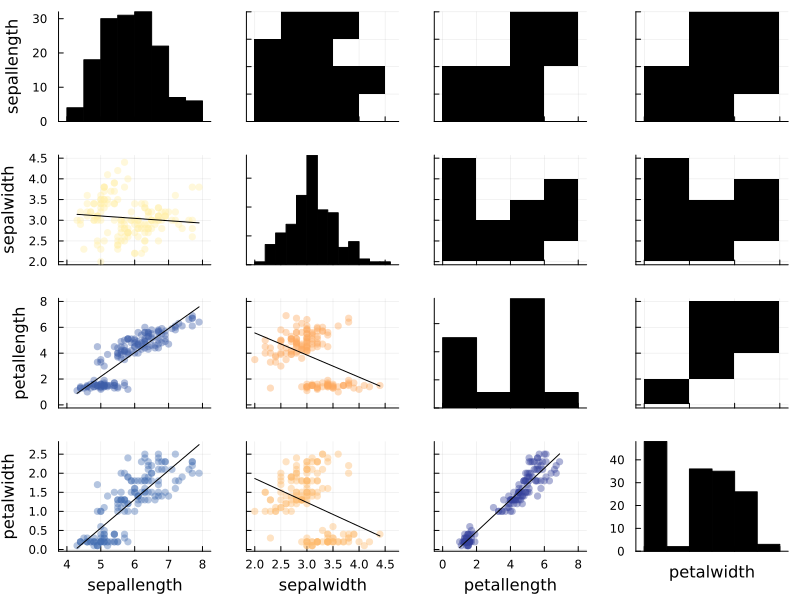

In [13]:
iris = Iris()

@show iris.dataframe |> describe

let metadata = iris.metadata
    @show metadata["n_observations"] metadata["target_names"]
end

@df iris.features corrplot(cols(oneto(size(iris.features,2))), size=(800,600))


##### 例：２値分類

In [14]:
let dataset = ClassifiData(tuple("Iris-setosa"),
		iris.features, iris.targets 
	)
	(; train, tester) = dataset
    
	h = fit(BinaryParams, train.features, train.targets)

	println("正答率　：　", count(
			argmax(x -> pdf(BinaryClassifi(h, feature), x), (true,false)) == target
			for (feature, target) in tester
		) / length(tester)
	)
end

正答率　：　1.0


##### 例：多値分類

In [15]:
let dataset = ClassifiData(unique(iris.targets).class,
		iris[union(1:40,51:90,101:140)],
		iris[union(41:50,91:100,141:150)]
	)
	(; train, tester) = dataset
	h = fit(MulticlassParams, length(dataset.class), train.features, train.targets)

	println("正答率　：　", 
		ratio(
            count(
				==(
                    argmax(x -> pdf(MulticlassClassifi(h, feature), x), eachindex(dataset.class)),
                    target
                )
				for (feature, target) in tester
			),
			length(tester)
		)
	)
end

正答率　：　1.0


### 回帰分析
ラベル変数の値域が連続的である場合、回帰分析となる。

線形回帰の他、ラベル変数が負の値をとらない場合はReLU回帰を用いる。
* 線形回帰： $d \in \mathbb{R}$
* ReLU回帰： $d \in \mathbb{R}^+_0$

In [16]:
"""
	RegressionParams{T} <: Hamiltonian{T}

回帰分析におけるハミルトニアン。

See also: [`RegressionParams`](@ref)
"""
abstract type RegressionParams{T<:AbstractFloat} <: Hamiltonian{T} end

"""
	RegressionAnalysys <: Canonical{Continuous}

回帰分析におけるカノニカル分布。

See also: [`RegressionAnalysys`](@ref)
"""
abstract type RegressionAnalysys <: Canonical{Continuous} end


RegressionAnalysys

#### 線形回帰
ラベル変数の値域を $d \in \mathbb{R}$ とする。
ハミルトニアンを
\begin{equation}
H(d,x) = - \frac{1}{2} (d - (\mathbb{J}x + J))^2
\end{equation}
とすると、カノニカル分布は正規分布になる：
\begin{equation}
p_J(d|x) = \frac{1}{2\pi} \exp \left[
	-\frac{1}{2} \left[ \left(d - (\mathbb{J} x + J) \right)^2 \right]
\right].
\end{equation}

ここで $i$ 番目のデータを $x_i$ ，教師信号を $d_i$ とすれば、
誤差関数の極値は定数項や定数倍に依存しないことを考慮すると、このハミルトニアンに対する誤差関数に次式を用いることができる。
\begin{equation}
L_J = \mathbb{E}_{X^n} [(d - (\mathbb{J} \cdot x + J) )^2]
	= \frac{1}{n} \sum_{i=1}^n (d_i - (\mathbb{J} \cdot x_i + J))^2
\end{equation}

実際、カノニカル分布の期待値が $\hat{d} = (\mathbb{J} \cdot x_i + J)$ であることを用いえれば、
カノニカル分布と誤差関数は次のように記述できる。
\begin{gather}
p_J(d|x) = \frac{1}{2\pi} \exp \left[
	-\frac{1}{2} \left[ \left(d - \hat{d} \right)^2 \right]
\right] 
\\
L_J = \mathbb{E}_{X^n} [(d - (\mathbb{J} \cdot x + J) )^2]
	= \frac{1}{n} \sum_{i=1}^n (d_i - \hat{d})^2
\end{gather}

以上より、このモデルでは誤差が標準正規分布に従うことを示しており、最小二乗法と，誤差・ノイズが正規分布に従うと仮定したときの最尤推定法とが等価であることが読み取れる。


In [17]:
"""
    LinearParams{T<:AbstractFloat} <: RegressionParams{T}

線形回帰のハミルトニアン。

See also: [`LinearRegression`](@ref), [`RegressionParams`](@ref)
"""
struct LinearParams{nf,T<:AbstractFloat} <: RegressionParams{T}
	v::Adjoint{T, MVector{nf,T}}
	v0::T
	LinearParams(v::Adjoint, v0::Real) = new{length(v),float(promote_eltype(v, v0))}(v, v0)
end
function LinearParams(v, v0::AbstractVector)
	@argcheck isone(length(v0)) DomainError
	LinearParams(v, only(v0))
end
LinearParams(v::AbstractVector, args...) = LinearParams(adjoint(v), args...)
LinearParams(v::Real, args...) = LinearParams(MVector(v)', args...)

LinearParams(features) = LinearParams(@MVector(ones(size(features,2)))', 0)


### utils
hamiltonian_expr(::Type{<:LinearParams}) = L"H(d,x) = - \frac{1}{2} (d - (Jx + J_0))^2"

ndims_features(::Type{<:LinearParams{nf,<:AbstractFloat}}) where nf = nf



ndims_features (generic function with 4 methods)

In [18]:
"""
	LinearRegression{nf,T<:AbstractFloat} <: RegressionAnalysys

２値分類のカノニカル分布。

See also: [`LinearParams`](@ref), [`RegressionAnalysys`](@ref)
"""
struct LinearRegression{nf,T<:AbstractFloat} <: RegressionAnalysys
	h::LinearParams{nf,T}
	features::SVector{nf,T}
	function LinearRegression(h::LinearParams, features; check_args=true)
		check_args && @check_args(LinearRegression, ndims_features(h)==length(features))
        nf = ndims_features(h)
        features_new = SVector{nf}(features)
        T_new = promote_eltype(h, features_new) |> float
		new{nf,T_new}(h, features_new)
	end
end

LinearRegression(features) = LinearRegression(LinearParams(features), features)

Canonical(::Type{<:LinearParams}) = LinearRegression


### statistics
StatsBase.mean(d::LinearRegression) = affine(d) # = v'*features + v0 # = dot(v, features) + v0

Distributions.pdf(d::LinearRegression, x::Real) = pdf(Normal(mean(d)), x)

loss(d::LinearRegression, x::Real) = abs2(x - mean(d))


loss (generic function with 4 methods)

#### ReLU(Rectified Linear Unit)回帰
 $N$ 個の補助的な自由度 $\{ h_\mathrm{bit}^{(u)} \in \{0,1\} \}_{u=1,\cdots,N}$ を用いたハミルトニアンを考える。（ここでは、$d \in \mathbb{R}_+$ を考える。）
\begin{gather}
H_{J,x}( \{ h_\mathrm{bit}^{(u)} \}_{u=1,\cdots,N} ) = - \sum_{u=1}^N (<\!\!J|x\!\!> + J_0 + 0.5 - u) h_\mathrm{bit}^{(u)} \\
H_h(d) = \frac{1}{2} (d - h)^2 \quad \left( h = \sum_{i=1}^N  h_\mathrm{bit}^{(u)} \right)
\end{gather}

ここでハミルトニアン $H_{J,x}$ は独立なハミルトニアン
\begin{equation}
H_{J,x}(h_\mathrm{bit}^{(u)}) = - (<\!\!J|x\!\!> + J_0 + 0.5 - u) h_\mathrm{bit}^{(u)}
\end{equation}
の足し合わせになっている。
この $\{ h_\mathrm{bit}^{(u)} \in \{0,1\} \}_{u=1,\cdots,N}$ のように、
アンサンブルを増やすことで性能が向上するという[報告](https://www.cs.toronto.edu/~hinton/absps/nips00-ywt.pdf)がある。

この時、$d$ の確率は次で与えられる。
\begin{align}
p_J(d|x)
	&= \mathbb{E}_{ \left\{ h_\mathrm{bit}^{(u)} \right\} } \left[ 
		p_h \left( d \, \middle| \, h=\sum_{u=1}^N h_\mathrm{bit}^{(u)}) \right)
	\right] \\
	&= \sum_{ \left\{ h_\mathrm{bit}^{(u)} \right\} } 
		p_h \left( d \, \middle| \, h=\sum_{u=1}^N h_\mathrm{bit}^{(u)} \right) \, p_J(\{h_\mathrm{bit}^{(u)}\} | x)
\end{align}

ここで $p_h \left( d|h=\sum_{u=1}^N h_\mathrm{bit}^{(u)} \right), \, p_J(\{h_\mathrm{bit}^{(u)}\} | x)$ は、以下で与えられるカノニカル分布である。
\begin{align}
p_J \left( \{ h_\mathrm{bit}^{(u)}\}|x \right)
	&= \prod_{u=1}^N \left\{
		\begin{array}
			& \sigma(<\!\!J|x\!\!> + J + 0.5 - u)	 & (h_\mathrm{bit}^{(u)} = 1) \\
			1 - \sigma(<\!\!J|x\!\!> + J + 0.5 - u) & (h_\mathrm{bit}^{(u)} = 0)
		\end{array}
	\right. \\
p_h(d|h) &= \frac{1}{2\pi} \exp\! \left[ - \frac{1}{2} (d-h)^2 \right]
\end{align}


In [19]:
struct ReLUParams{nf,T<:AbstractFloat} <: Hamiltonian{T}
	v::Adjoint{T, MVector{nf,T}}
	v0::T
	ReLUParams(v::Adjoint, v0::Real) = new{length(v),float(promote_eltype(v,v0))}(v, v0)
end
ReLUParams(v::AbstractVector, args...) = ReLUParams(adjoint(v), args...)
ReLUParams(v::Real, args...) = ReLUParams(MVector(v)', args...)
function ReLUParams(v, v0::AbstractVector)
    @argcheck isone(length(v0)) DomainError
    ReLUParams(v, only(v0))
end

ReLUParams(features) = ReLUParams(@MVector(ones(size(features,2)))', 0)


### utils
hamiltonian_expr(::Type{<:ReLUParams}) = (
	BK"H_{J,x}( \{ h_\mathrm{bit}^{(u)} \}_{u=1,\cdots,N} )
	= - \sum_{u=1}^N (\<J|x\> + J_0 + 0.5 - u) h_\mathrm{bit}^{(u)}",
	BK"H_h(d) = \frac{1}{2} (d - h)^2 \quad \left( h = \sum_{i=1}^N  h_\mathrm{bit}^{(u)} \right)",
)

ndims_features(::Type{<:ReLUParams{nf,<:AbstractFloat}}) where nf = nf



ndims_features (generic function with 5 methods)

In [20]:
struct ReLURegression{nf,T<:AbstractFloat} <: RegressionAnalysys
	h::ReLUParams{nf,T}
	features::SVector{nf,T}
	function ReLURegression(h::ReLUParams{nf,<:AbstractFloat}, features::AbstractVector; check_args::Bool=true) where nf
		check_args && @check_args(ReLURegression, nf==length(features))
        new{nf,promote_eltype(h,features)}(h, features)
    end
end

ReLURegression(features) = ReLURegression(ReLUParams(features), features)

Canonical(::Type{<:ReLUParams}) = ReLURegression



### statistics
# pdf
function Distributions.pdf(d::ReLURegression, x::AbstractVector, c::Real=0.5)
	(; h, features) = d
	(; v, v0) = h
    
	p = one(v0)
	for (i, xi) in enumerate(x)
		p *= pdf(Bernoulli((σ∘muladd)(v, features, v0 + c - i)), xi)
		p *= pdf(BernoulliLogit(muladd(v, features, v0 + c - i)), xi)
	end
	p
end

Distributions.pdf(::ReLURegression, x::Real, bits::AbstractVector{Bool}) = pdf(Normal(count(bits)), x)

function Distributions.pdf(d::ReLURegression, x::Real, n::Integer, c::Real=0.5)
	p = zero(eltype(d))
	hvec = MVector{n,Bool}(undef)
    
	for bits in 0x0:ifelse(n>16, UInt32, UInt16)(0x2)^n-0x1
        bstr = bitstring(bits)
        for i in oneto(n)
            hvec[i] = parse(Bool, bstr[end-i+one(i)])
        end
		p += pdf(d, x, hvec) * pdf(d, hvec, c)
	end
	p
end


# mean
function StatsBase.mean(d::ReLURegression, n::Integer, c::Real=0.5)
    ex = zero(eltype(d))
    hvec = MVector{n,Bool}(undef)
    
  	for num in 0x0:ifelse(n>16, UInt32, UInt16)(0x2)^n-0x1
    	bstr = bitstring(num)
    	for i in oneto(n)
    		hvec[i] = parse(Bool, bstr[end-i+firstindex(hvec)])
    	end
    	ex += count(hvec) * pdf(d, hvec, c)
    end
    ex
end


##### ReLU回帰の近似
予測分布の簡単化のために、次のような近似を試みる：
\begin{equation}
p_J(d|x)
	= \mathbb{E}_{ \left\{ h_\mathrm{bit}^{(u)} \right\} } \left[ 
		p_h \left( d \, \middle| \, h=\sum_{u=1}^N h_\mathrm{bit}^u \right)
	\right]
	\approx p_h \left( d \, \middle| \, 
		h = \mathbb{E}_{ \left\{ h_\mathrm{bit}^{(u)} \right\} }
		\left[ \sum_{u=1}^N h_\mathrm{bit}^u \right]
	\right).
\end{equation}
つまり、確率平均からサンプル平均への置き換えと同様の置き換えを行う。

このときの誤差関数は、線形回帰の場合と同様にして得られる：
\begin{equation}
L_J = \mathbb{E}_{X^n} \left[ \left( d - \mathbb{E}_{
		\left\{ h_\mathrm{bit}^{(u)} \right\} 
	}
	\left[ \sum_{u=1}^N h_\mathrm{bit}^u \right] \right)^2 \right]
	= \frac{1}{n} \sum_{i=1}^n \left( d_i - \mathbb{E}_{
		\left\{ h_\mathrm{bit}^{(u)} \right\} 
	}
		\left[ \sum_{u=1}^N h_\mathrm{bit}^((u)) \right]
	\right)^2
\end{equation}


アンサンブル $h_\mathrm{bit}^{(u)}$ の独立であるから（あるいは期待値の線形性からも得られる）、次が成立する。
\begin{equation}
\mathbb{E}_{\left\{ h_\mathrm{bit}^{(u)} \right\}} \! \left[
	\sum_{u=1}^N h_\mathrm{bit}^{(u)}
\right]
= \sum_{u=1}^N \mathbb{E}_{h_\mathrm{bit}^{(u)}} \! \left[
    h_\mathrm{bit}^{(u)}
\right]
\end{equation}
今、$H_{J,x}(h_\mathrm{bit}^{(u)})$ の取りうる値は２つのみであるから、２値分類と同じくシグモイド関数 $\sigma(x) = 1/(1-e^x)$ を用いて
\begin{equation}
\mathbb{E}_{\left\{ h_\mathrm{bit}^{(u)} \right\}} \! \left[
	\sum_{u=1}^N h_\mathrm{bit}^u
\right]
	= \sum_{u=1}^N \sigma(<J|x> + J + 0.5 - u)
\end{equation}
と記述できる。よって
\begin{equation}
\mathbb{E}_{\left\{ h_\mathrm{bit}^{(u)} \right\}} \! \left[
	\sum_{u=1}^N h_\mathrm{bit}^{(u)}
\right]
\approx \mathrm{act}(x) := \sum_{u=1}^N \sigma(x + 0.5 - u)
\end{equation}
が成立すると予想できる。このことを確かめる。


In [21]:
# sigmoid function
function StatsBase.mean(d::ReLURegression, n::Integer, c::Real)
    @argcheck 0 < n DomainError
    (; h, features) = d
    (; v, v0) = h
    sum(σ, muladd(v, features, v0 + c - i) for i in oneto(n))
end

# activation function
act(x::Real, n::Integer=10, c::Real=0.5) = sum(σ(x+c-i) for i in oneto(n))


act (generic function with 3 methods)

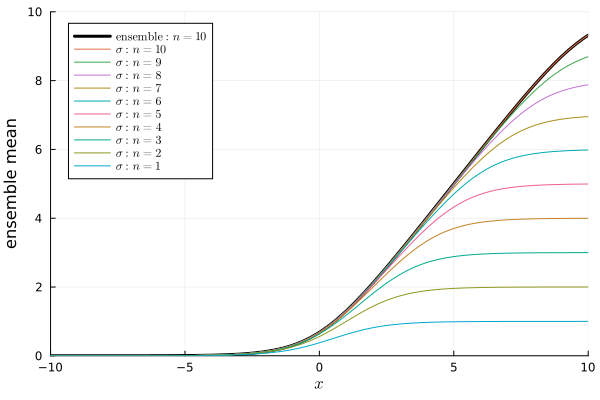

In [22]:
let n = 10, h = ReLUParams(1, 0)
    plt = plot(; 
    	title=L"\sigma_n(x) = \sum_{i=1}^{n}\sigma(x+0.5-i)", titlefontsize=12, 
    	xaxis=(L"x", (-n,n), ), 
    	yaxis=("activation function", (0,n), ), 
    )
    
    plot!(x->mean(ReLURegression(h, SVector(x)), n);
        title="", ylabel="ensemble mean", 
        label=L"\mathrm{ensemble : } n="*latexstring(n), color=:black, linewidth=3, 
    )
    
    for i in n:-1:1
        plot!(z->act(z,i); label=L"\sigma : n=%$i")
    end
    
    savefig(joinpath(@__DIR__, "../texfile/figures/relu_ensamble.pdf"))
    plt
end

さらにこの結果から、期待値は $n \gg 1$ であれば
\begin{equation}
\mathbb{E}_{
	\left\{ h_\mathrm{bit}^{(u)} \right\}
} \left[ \sum_{u=1}^N h_\mathrm{bit}^u \right]
	\approx \max(0, x) ≕ \sigma_\mathrm{ReLU}(x)
\end{equation}
と近似できると予想できる。

このときの確率 $p_J(d|x)$ は
\begin{align}
p_J(d|x)
    & \approx p_h \! \left( d \, \middle| \, h = \sigma_\mathrm{ReLU}(<J|x> + J)	\right) \\
	& = \frac{1}{\sqrt{2\pi}} \, \exp  \left[
		\frac{1}{2} \left( d-\sigma_\mathrm{ReLU}(<J|x> + J) \right)^2
	\right].
\end{align}
であり、誤差関数は次で与えられる：
\begin{equation}
L_J = \mathbb{E}_{X^n} \left[
		\left(d - \sigma_\mathrm{ReLU}(<J|x> + J) \right)^2
	\right]
	= \frac{1}{n} \sum_{i=1}^n \left( d_i - \sigma_\mathrm{ReLU}(<J|x_i> + J)	\right)^2 .
\end{equation}

ここで、ReLU回帰における誤差は厳密には正規分布に従わないことに注意する。

In [23]:
### statistics
σ_relu(x::Real) = max(zero(x), x)

StatsBase.mean(d::ReLURegression) = (σ_relu∘affine)(d)

Distributions.pdf(d::ReLURegression, x::Real) = pdf(Normal(mean(d)), x)

loss(d::ReLURegression, x::Real) = abs2(x - mean(d))


loss (generic function with 5 methods)

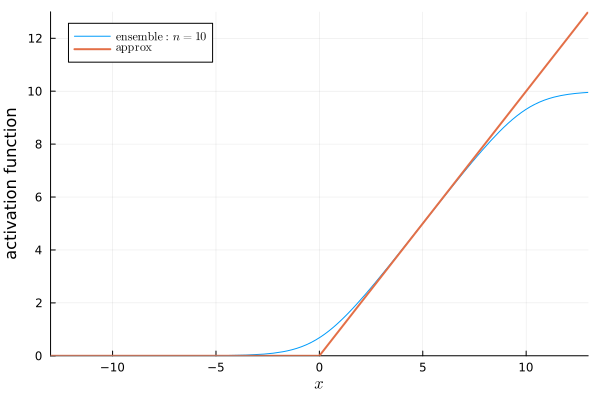

In [24]:
#=
let n = 10
    h = ReLUParams(1, 0)
    
    plt = plot(; 
    	#title=L"\sigma_n(x) = \sum_{i=1}^{n}\sigma(x+0.5-i)", titlefontsize=12, 
        title="", ylabel="ensemble mean", 
    	xaxis=(L"x", (-n-3,n+3), ), 
    	yaxis=("activation function", (0,n+3), ), 
    )
    plot!(x->mean(ReLURegression(h, SVector(x)), n);
        label=L"\mathrm{ensemble : } n="*latexstring(n), 
    )
    plot!(x -> mean(ReLURegression(h, SVector(x)));
        label=L"\mathrm{approx}", linewidth=2, 
    )
    
    savefig(joinpath(@__DIR__, "../texfile/figures/relu_sim.pdf"))
    plt
end
=#
@manipulate for n = 1:15
    h = ReLUParams(1, 0)
    
    plt = plot(; 
    	#title=L"\sigma_n(x) = \sum_{i=1}^{n}\sigma(x+0.5-i)", titlefontsize=12, 
        title="", ylabel="ensemble mean", 
    	xaxis=(L"x", (-n-3,n+3), ), 
    	yaxis=("activation function", (0,n+3), ), 
    )
    plot!(x->mean(ReLURegression(h, SVector(x)), n);
        label=L"\mathrm{ensemble : } n="*latexstring(n), 
    )
    plot!(x -> mean(ReLURegression(h, SVector(x)));
        label=L"\mathrm{approx}", linewidth=2, 
    )
    
    savefig(joinpath(@__DIR__, "../texfile/figures/relu_sim.pdf"))
    plt
end

#### アルゴリズムの検証：Bonston house-prices 
持ち家の価格と、その地域に関する指標からなるデータセット。
持ち家の価格を推測する。


In [25]:
"""
    RegressionData{Tf<:AbstractMatrix,Tt<:AbstractVector{<:AbstractFloat}}



See also: [`TData`](@ref)
"""
struct RegressionData{Tf<:AbstractMatrix,Tt<:AbstractVector}
	train::TData{Tf,Tt}
	tester::TData{Tf,Tt}
	function RegressionData(train::TData{Tf,Tt}, tester::TData{Tf,Tt}) where {Tf<:AbstractMatrix{<:Real},Tt<:AbstractVector{<:Real}}
		@argcheck size(train.features, 1) == size(train.targets , 1) DimensionMismatch
		@argcheck size(tester.features, 1) == size(tester.targets , 1) DimensionMismatch
		T_new = promote_eltype(Tf, Tt) |> float
		new{Matrix{T_new},Vector{T_new}}(train, tester)
	end
end

function RegressionData(features, targets; shuffle::Bool=true,  at=0.8)
	train, test = splitobs((features, targets); at=at, shuffle=shuffle)
	RegressionData(TData(train), TData(test))
end


RegressionData

The Boston Housing Dataset.

Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

Number of Instances: 506

Number of Attributes: 13 continuous attributes (including target
                            attribute "MEDV"), 1 binary-valued attribute.

Features:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of own

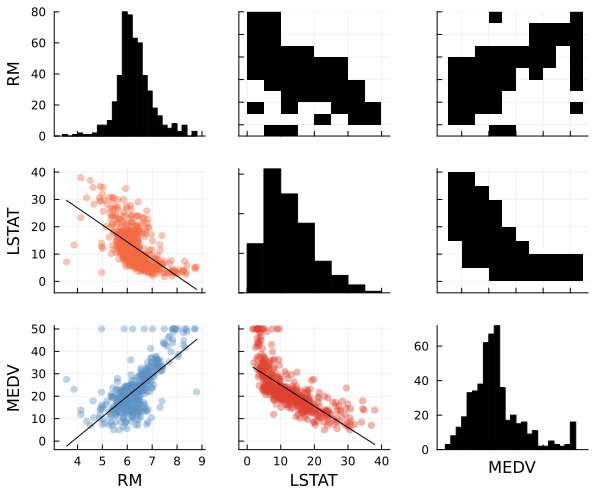

In [26]:
bh = BostonHousing()

bh.metadata["description"] |> println

@show bh.dataframe |> describe

@df bh.dataframe corrplot([:RM :LSTAT :MEDV], size=(600,500))


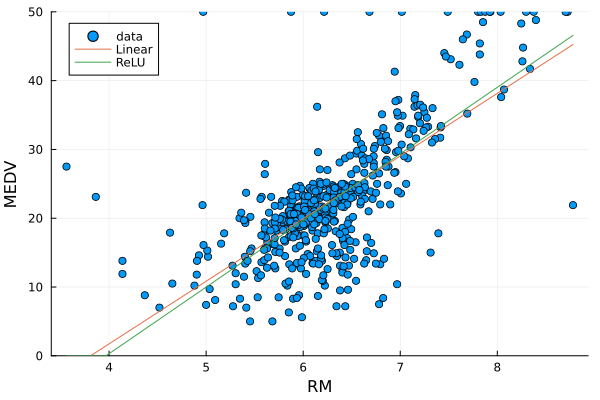

In [27]:
let 
    #=
    dataset = RegressionData(bh.features, bh.targets; at=0.75)
	(; train, tester) = dataset
    x, y = train.features[:,6], train.targets
    =#
    x, y = bh.features[:, 6], bh.targets[:,1]

	h_linr = fit(LinearParams, x, y; result=false, )
	h_relu = fit(ReLUParams, x, y; result=false, )
    
    plt = scatter(x, y; label="data", xlabel="RM", yaxis=("MEDV", (0,Inf), ), )
    plot!(plt, x -> mean(LinearRegression(h_linr, SVector(x))); label="Linear", )
    plot!(plt, x -> mean(ReLURegression(h_relu, SVector(x))); label="ReLU", )
    display(plt)

    nothing
end

ここで線形回帰分析においても、非線形的な効果も考慮することができることに注意する。

例えばLSTATに対数を，MEDVに平方根をとることでよりデータにフィットする関数が得られる。

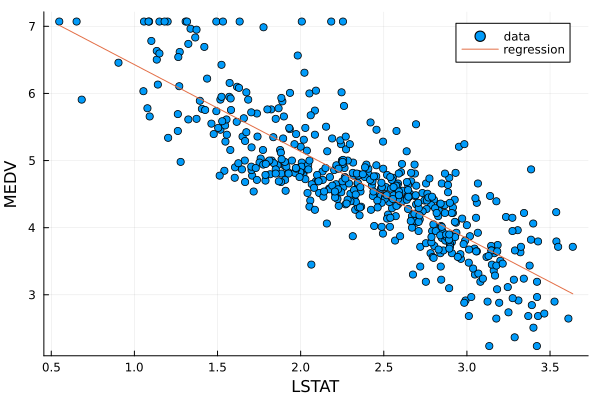

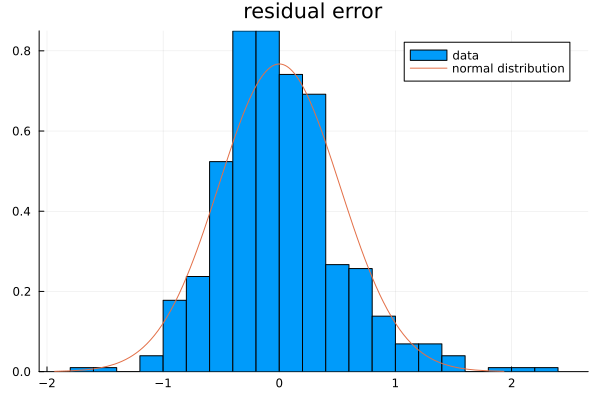

In [28]:
let 
    #=
    dataset = RegressionData(bh.features, bh.targets; at=0.75)
	(; train, tester) = dataset
    x, y = train.features[:,13], train.targets[:,1]
    =#
    x, y = log.(bh.features[:, 13]), sqrt.(bh.targets[:,1])
    h = fit(LinearParams, x, y)
    
    plt = plot(; xlabel="LSTAT", ylabel="MEDV", )
    scatter!(x, y; label="data", )
    plot!(plt, x -> mean(LinearRegression(h, SVector(x))); label="regression", )
    display(plt)
    
    plt = plot(; title="residual error", )
    histogram!(x, y.-map(xi->mean(LinearRegression(h, SVector(xi))), x); normalize=:pdf, label="data", )
    plot!(fit(Normal, y.-map(xi->mean(LinearRegression(h, SVector(xi))), x)); label="normal distribution")
    display(plt)

    nothing
end

### ベイズ回帰


### 深層ニューラルネットワーク


#### 深層化


#### 逆伝播法


#### 万能近似定理
万能近似定理（普遍性定理）

